In [1]:
%load_ext autoreload
%autoreload 2   

In [2]:
import numpy as np
import random
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import torchvision

seed = 0
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import sys

sys.path.append("../")
from mftma.manifold_analysis_correlation import manifold_analysis_corr
from mftma.utils.make_manifold_data import make_manifold_data
from mftma.utils.activation_extractor import extractor
from mftma.utils.analyze_pytorch import analyze

In [ ]:
from avalanche.training import EWC

# from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.benchmarks.classic import SplitCIFAR100
from avalanche.models.pytorchcv_wrapper import resnet
from avalanche.models import SimpleMLP
from avalanche.training import Naive
from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint

/home/anirudh/ManifoldCapacityCL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Config
# model
# model = SimpleMLP(num_classes=10)
model = torchvision.models.vgg16(num_classes=100).to(device)

# CL Benchmark Creation
# perm_mnist = PermutedMNIST(n_experiences=3, seed=0)
perm_mnist = SplitCIFAR100(n_experiences=1, seed=0)
train_stream = perm_mnist.train_stream
test_stream = perm_mnist.test_stream

# Prepare for training & testing
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()

# Continual learning strategy
cl_strategy = Naive(
    model,
    optimizer,
    criterion,
    train_mb_size=32,
    train_epochs=100,
    eval_mb_size=32,
    device=device,
)

# cl_strategy, initial_exp = maybe_load_checkpoint(cl_strategy, "./0_checkpoint.pth")

# train and test loop over the stream of experiences
results = []
for c, train_exp in enumerate(train_stream):
    # cl_strategy.eval(test_stream)
    cl_strategy.train(train_exp)
    save_checkpoint(cl_strategy, f"{c}_checkpoint.pth")
    # torch.save({"data": train_exp}, f"{c}_data.pth")
    results.append(cl_strategy.eval(test_stream))

Files already downloaded and verified
Files already downloaded and verified


/home/anirudh/ManifoldCapacityCL/.venv/lib/python3.10/site-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the Naive.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)


-- >> Start of training phase << --
0it [00:00, ?it/s]

/home/anirudh/ManifoldCapacityCL/.venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


100%|██████████| 1563/1563 [00:31<00:00, 49.61it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.7817
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7957
100%|██████████| 1563/1563 [00:33<00:00, 46.93it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.7445
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7957
100%|██████████| 1563/1563 [00:32<00:00, 47.38it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.7261
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7979
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 313/313 [00:03<00:00, 95.39it/s] 
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0788
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6959
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 1.0788
	Top1_Acc_Stream/eval_phase

In [11]:
mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

train_dataset = datasets.CIFAR100(
    "../data", train=True, download=True, transform=transform_train
)
test_dataset = datasets.CIFAR100(
    "../data",
    train=False,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(mean, std)]
    ),
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
sampled_classes = 100
examples_per_class = 50

data = make_manifold_data(train_dataset, sampled_classes, examples_per_class, seed=0)
data = [d.to(device) for d in data]

In [13]:
model = model.eval()

In [14]:
activations = extractor(model, data, layer_types=["Conv2d", "Linear"])
list(activations.keys())

/home/anirudh/ManifoldCapacityCL/.venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


['layer_0_Input',
 'layer_1_Conv2d',
 'layer_4_Conv2d',
 'layer_7_Conv2d',
 'layer_10_Conv2d',
 'layer_13_Conv2d',
 'layer_16_Conv2d',
 'layer_19_Conv2d',
 'layer_27_Conv2d',
 'layer_22_Conv2d',
 'layer_25_Conv2d',
 'layer_30_Conv2d',
 'layer_33_Conv2d',
 'layer_36_Conv2d',
 'layer_39_Conv2d',
 'layer_47_Conv2d',
 'layer_42_Conv2d',
 'layer_45_Conv2d',
 'layer_50_Conv2d',
 'layer_53_Conv2d',
 'layer_56_Conv2d',
 'layer_59_Conv2d',
 'layer_63_Linear']

In [15]:
for layer, data in activations.items():
    X = [d.reshape(d.shape[0], -1).T for d in data]
    # Get the number of features in the flattened data
    N = X[0].shape[0]
    # If N is greater than 5000, do the random projection to 5000 features
    if N > 5000:
        print("Projecting {}".format(layer))
        M = np.random.randn(5000, N)
        M /= np.sqrt(np.sum(M * M, axis=1, keepdims=True))
        X = [np.matmul(M, d) for d in X]
    activations[layer] = X

Projecting layer_1_Conv2d
Projecting layer_4_Conv2d
Projecting layer_7_Conv2d
Projecting layer_10_Conv2d
Projecting layer_13_Conv2d
Projecting layer_16_Conv2d
Projecting layer_19_Conv2d
Projecting layer_27_Conv2d
Projecting layer_22_Conv2d
Projecting layer_25_Conv2d
Projecting layer_30_Conv2d
Projecting layer_33_Conv2d
Projecting layer_36_Conv2d
Projecting layer_39_Conv2d


In [19]:
capacities = []
radii = []
dimensions = []
correlations = []

for k, X in activations.items():
    # Analyze each layer's activations
    a, r, d, r0, K = manifold_analysis_corr(X, 0, 300, n_reps=1)

    # Compute the mean values
    a = 1 / np.mean(1 / a)
    r = np.mean(r)
    d = np.mean(d)
    print(
        "{} capacity: {:4f}, radius {:4f}, dimension {:4f}, correlation {:4f}".format(
            k, a, r, d, r0
        )
    )

    # Store for later
    capacities.append(a)
    radii.append(r)
    dimensions.append(d)
    correlations.append(r0)

layer_0_Input capacity: 0.039625, radius 1.577459, dimension 35.062391, correlation 0.334765
layer_1_Conv2d capacity: 0.039803, radius 1.551755, dimension 35.145729, correlation 0.260829
layer_4_Conv2d capacity: 0.040735, radius 1.498179, dimension 35.011861, correlation 0.174358
layer_7_Conv2d capacity: 0.040653, radius 1.483237, dimension 35.287317, correlation 0.091963
layer_10_Conv2d capacity: 0.040748, radius 1.480783, dimension 35.290444, correlation 0.086813
layer_13_Conv2d capacity: 0.040670, radius 1.478884, dimension 35.501008, correlation 0.135721
layer_16_Conv2d capacity: 0.040878, radius 1.469326, dimension 35.341200, correlation 0.051343
layer_19_Conv2d capacity: 0.040522, radius 1.482923, dimension 35.504502, correlation 0.135336
layer_27_Conv2d capacity: 0.041116, radius 1.476002, dimension 35.116303, correlation 0.194355
layer_22_Conv2d capacity: 0.041066, radius 1.473777, dimension 35.171797, correlation 0.153927
layer_25_Conv2d capacity: 0.041362, radius 1.474011, di

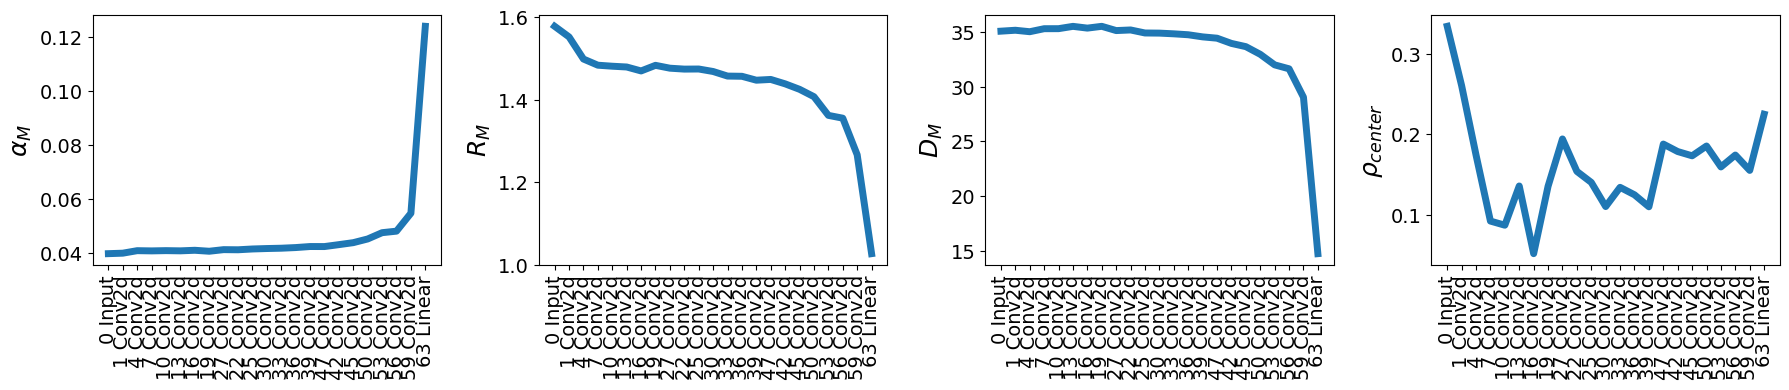

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

axes[0].plot(capacities, linewidth=5)
axes[1].plot(radii, linewidth=5)
axes[2].plot(dimensions, linewidth=5)
axes[3].plot(correlations, linewidth=5)

axes[0].set_ylabel(r"$\alpha_M$", fontsize=18)
axes[1].set_ylabel(r"$R_M$", fontsize=18)
axes[2].set_ylabel(r"$D_M$", fontsize=18)
axes[3].set_ylabel(r"$\rho_{center}$", fontsize=18)

names = list(activations.keys())
names = [n.split("_")[1] + " " + n.split("_")[2] for n in names]
for ax in axes:
    ax.set_xticks([i for i, _ in enumerate(names)])
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.tick_params(axis="both", which="major", labelsize=14)

plt.tight_layout()
plt.show()